# GIS Practicum Project
____________________________________
## Impact of Extreme Weather Events on Railway Incidents
### Determining high risk locations where monitoring stations could be installed

Data Sources:

    1. NOAA Reference Data:
        - source: ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/
        - local files: ghcnd-stations.txt & ghcnd-states.txt
        - use: reference data for daily weather station files
    2. NOAA Daily Weather Data:
        - source: ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/
        - local files: ghcnd_hcn.tar.gz
        - use: granular weather data by station
    3. U.S. Cities Data:
        - source: https://github.com/kelvins/US-Cities-Database/blob/main/csv/us_cities.csv
        - local files: us_cities.csv
        - use: mapping between datasets
    4. Railroad Grade Crossing Incident Data:
        - source: https://data.transportation.gov/Railroads/Highway-Rail-Grade-Crossing-Accident-Data/7wn6-i5b9
        - local files: Highway-Rail_Grade_Crossing_Accident_Data.csv
        - use: main incident dataset
    5. Weather Events:
        - source: https://www.kaggle.com/sobhanmoosavi/us-weather-events
        - local file: WeatherEvents_Jan2016-Dec2020.csv
        - use: major U.S. weather events, 6.3m over 5yr period
    
Outline:
    1. Environment setup
    2. Data loading & Preprocessing
    3. EDA & Visualization
    4. Prep for scikit learn
    5. Model Building & Evaluation

## 1. Environment Setup
___

In [1]:
import csv
import glob
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import os
import pandas as pd
import seaborn as sns

Set Matplotlib Style:

In [2]:
plt.style.use('dark_background')

Get Current Working Directory:

In [3]:
wd = os.getcwd()
print(wd)

C:\Users\thoma\Desktop\Rutgers MBS\Externship Class\Practicum\Project


Establish Constants:

In [4]:
# define relevant years list for treatments
relevant_years_list = [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]

## 2. Data Loading & Preprocessing
___

### Source 1: NOAA Reference Data:

#### Stations:

In [5]:
def load_noaa_stations_data(wd):
    """
    This function will load the weather station dataset from NOAA
    this is used for mapping to rail crossing locations.
    
    Contains weather station reference data
    
    Source: ghcnd-stations.txt from NOAA ftp
    Input: wd - working directory
    Output: stations_df - dataframe of NOAA stations
    """
    f = open(os.path.join(wd,"ghcnd-stations.txt"),"r")
    lines = f.readlines()

    # columns in the station file
    colnames = ['ID', 'LAT', 'LON', 'ELEV', 'STATE', 'NAME', 'GSN', 'HCNCRN', 'WMOID']
    stationlist = []

    # initialize dataframe with correct columns
    stations_df = pd.DataFrame(columns=colnames)

    # iterate through stations and add them to our collection of stations if they are in the US
    for line in lines:
        # first 2 characters are the country code , we only care about us stations
        if line[0:2] == 'US':

            # the description of the file seemed slightly off, i tested and found these column numbers to work best
            row = {"ID": line[0:11].upper(),
                    "LAT": float(line[13:20]),
                    "LON": float(line[21:30]),
                    "ELEV": float(line[31:37]),
                    "STATE": line[38:40],
                    "NAME": line[41:71],
                    "GSN": line[72:75],
                    "HCNCRN": line[76:79],
                    "WMOID": line[80:85]
                   }
            stationlist.append(row)
        else:
            pass
    stations_df = stations_df.append(stationlist)
    f.close()
    
    return stations_df

In [6]:
stations_df = load_noaa_stations_data(wd)

In [7]:
stations_df.head()

,ID,LAT,LON,ELEV,STATE,NAME,GSN,HCNCRN,WMOID
0,US009052008,43.7333,-96.6333,482.0,SD,SIOUX FALLS (ENVIRON. CANADA),,,
1,US10RMHS145,40.5268,-105.1113,1569.1,CO,RMHS 1.6 SSW,,,
2,US10ADAM001,40.5680,-98.5069,598.0,NE,JUNIATA 1.5 S,,,
3,US10ADAM002,40.5093,-98.5493,601.1,NE,JUNIATA 6.0 SSW,,,
4,US10ADAM003,40.4663,-98.6537,615.1,NE,HOLSTEIN 0.1 NW,,,


#### States:

In [8]:
def load_noaa_states_data(wd):
    """
    This function will load the state dataset from NOAA
    this is used for mapping to rail crossing locations.
    
    Contains state reference data
    
    Source: ghcnd-states.txt from NOAA ftp
    Input: wd - working directory
    Output: states_df - dataframe of NOAA states
    """
    # read in states dataset to supplement weather stations data
    f = open(os.path.join(wd,"ghcnd-states.txt"),"r")
    lines = f.readlines()

    colnames = ['CODE', 'NAME']

    # create dataframe of state data
    states_df = pd.DataFrame(columns=colnames)
    for line in lines:
        modline = line.strip('\n')
        data = {'CODE': line[0:2],
                "NAME": modline[3:50]
               }
        states_df = states_df.append(data, ignore_index=True)    

    f.close()
    return states_df

In [9]:
states_df = load_noaa_states_data(wd)

In [10]:
states_df.head()

,CODE,NAME
0,AB,ALBERTA
1,AK,ALASKA
2,AL,ALABAMA
3,AR,ARKANSAS
4,AS,AMERICAN SAMOA


#### NOAA Reference Data Merge:

In [11]:
def merge_noaa_refdata(stations_df, states_df):
    """
    This function will merge the NOAA refdata
    this is used for mapping to rail crossing locations.
    
    Contains state & station reference data
    
    Input: stations_df, states_df
    Output: stations_plus_df - dataframe of NOAA refdata
    """
    
    # add state data to the stations dataset
    station_plus_df = stations_df.join(states_df.set_index('CODE'), on='STATE', rsuffix='_STATE')

    # create our key feature: coordinateID (wcoordinateID for weather)
    # round latitude & longitude to 1 decimal, combine them in a tuple (lat, lon)
    station_plus_df['wcoordinateID'] = list(zip(round(station_plus_df['LAT'],1),round(station_plus_df['LON'],1)))
    station_plus_df = station_plus_df[['ID','ELEV','wcoordinateID']]
    
    return station_plus_df

In [12]:
station_plus_df = merge_noaa_refdata(stations_df, states_df)

In [13]:
station_plus_df.head()

,ID,ELEV,wcoordinateID
0,US009052008,482.0,"(43.7, -96.6)"
1,US10RMHS145,1569.1,"(40.5, -105.1)"
2,US10ADAM001,598.0,"(40.6, -98.5)"
3,US10ADAM002,601.1,"(40.5, -98.5)"
4,US10ADAM003,615.1,"(40.5, -98.7)"


### Source 3: U.S. Cities:

In [14]:
def load_us_cities_data(wd):
    """
    This function will load cities data which will 
    be used to attach coordinateID to other datasets 
    which only have city or county level data.
    Also derives county locations.
    
    Input: wd - working directory
    Output: grouped_meancounties_df
    """
    cities_df = pd.read_csv(os.path.join(wd,"us_cities.csv"))
    
    # standardize county and state, city is not populated for all events.
    # one change to approach would be to include all cities + the grouped mean of each county
    cities_df['County'] = cities_df['COUNTY'].str.upper()
    cities_df['State'] = cities_df['STATE_NAME'].str.upper()

    # subset of data that we care about, lat+lon to make coordinateID, county, state, state code to merge on
    counties = cities_df[['County','State','LATITUDE','LONGITUDE','STATE_CODE']]
    grouped_counties = counties.groupby(['State','County'])
    grouped_meancounties_df = grouped_counties.mean()
    grouped_meancounties_df = grouped_meancounties_df.reset_index()
    grouped_meancounties_df['wcoordinateID'] = list(zip(round(grouped_meancounties_df['LATITUDE'],1),round(grouped_meancounties_df['LONGITUDE'],1)))
    
    return grouped_meancounties_df

In [15]:
grouped_meancounties_df = load_us_cities_data(wd)

In [16]:
grouped_meancounties_df.head()

,State,County,LATITUDE,LONGITUDE,wcoordinateID
0,ALABAMA,AUTAUGA,32.549984,-86.638759,"(32.5, -86.6)"
1,ALABAMA,BALDWIN,30.583510,-87.732460,"(30.6, -87.7)"
2,ALABAMA,BARBOUR,31.817987,-85.441254,"(31.8, -85.4)"
3,ALABAMA,BIBB,33.027422,-87.071602,"(33.0, -87.1)"
4,ALABAMA,BLOUNT,33.937479,-86.598022,"(33.9, -86.6)"


### Source 4: Rail Crossing Data:

In [17]:
def load_rail_crossing_data(wd, grouped_meancounties_df):
    """
    This function will load data for rail crossings
    which will be used for instances for model training.
    Will also be used to limit weather station observations
    
    Input: wd - working directory, grouped_meancounties_df - location base data
    Output: rail_city_df
    """
    railcrossing_df = pd.read_csv(os.path.join(wd,"Highway-Rail_Grade_Crossing_Accident_Data.csv"))
    
    # gather the fields necessary for coordinateID, as well as any  fields you want for analysis later 
    # change to approache what fields we include in refined_rr
    refined_rr_df = railcrossing_df #[['Incident Number','Date','County Name', 'State Name']]

    # drop any incident without a date
    refined_rr_df = refined_rr_df.dropna(subset=['Date'])

    # create our feature incident date, which is an integer with format: yyyymmdd 
    incident_date = refined_rr_df['Date'].str.split(' ', expand=True)
    incident_date = incident_date[0].str.split('/', expand=True)
    refined_rr_df['incident_date'] = (incident_date[2].astype(int) * 10000) + (incident_date[0].astype(int) * 100) + (incident_date[1].astype(int) * 1)

    # merge accident data with city/county data to add coordinateID to each accident.
    merg_rail_city_df = refined_rr_df.merge(grouped_meancounties_df, how='inner', left_on=['County Name','State Name'], right_on=['County','State'])
    print("Shape of merged unfiltered rail_city dataset:  {}".format(merg_rail_city_df.shape))
    merg_rail_city_df = merg_rail_city_df[merg_rail_city_df['incident_date'] > 20140000]
    merg_rail_city_df = merg_rail_city_df[['Grade Crossing ID', 
                                           'Maintenance Parent Railroad Code', 
                                           'Incident Number',
                                           'Crossing Illuminated',
                                           'Railroad Type',
                                           'Track Type Code', 
                                           'incident_date', 
                                           'wcoordinateID', 
                                           'State', 
                                           'County'
                                          ]]
    print("Shape of merged filtered rail_city dataset:  {}".format(merg_rail_city_df.shape))
    
    return merg_rail_city_df

In [18]:
merg_rail_city_df = load_rail_crossing_data(wd, grouped_meancounties_df)

c:\users\thoma\appdata\local\programs\python\python36\lib\site-packages\IPython\core\interactiveshell.py:2903: DtypeWarning: Columns (6,7,8,25,26,38,42,50,51,52,53,59,64,69,87,88,89,95,97,98,99,100,101,106,119,122,126,127,128,129,139,147,148,149,150,151,152) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
c:\users\thoma\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Shape of merged unfiltered rail_city dataset:  (232065, 165)
Shape of merged filtered rail_city dataset:  (15845, 10)


In [19]:
def pre_process_rail(merg_rail_city_df):
    """
    This function will preprocess rail df.
    Focus is on datetime formats
    
    input: merg_rail_city_df
    output: enriched merg_rail_city_df
    """
    
    merg_rail_city_df['incident_datetime'] = pd.to_datetime(merg_rail_city_df['incident_date'], format='%Y%m%d')
    merg_rail_city_df['incident_year'] = merg_rail_city_df['incident_datetime'].dt.year
    merg_rail_city_df['incident_month'] = merg_rail_city_df['incident_datetime'].dt.month
    merg_rail_city_df['incident_year_month'] = merg_rail_city_df['incident_year'].astype(str) + '_' + merg_rail_city_df['incident_month'].astype(str)
    
    return merg_rail_city_df

In [20]:
merg_rail_city_df = pre_process_rail(merg_rail_city_df)

In [21]:
merg_rail_city_df.head()

,Grade Crossing ID,Maintenance Parent Railroad Code,Incident Number,Crossing Illuminated,Railroad Type,Track Type Code,incident_date,wcoordinateID,State,County,incident_datetime,incident_year,incident_month,incident_year_month
3,028445G,BNSF,144902,No,No,1.0,20161031,"(36.7, -119.7)",CALIFORNIA,FRESNO,2016-10-31,2016,10,2016_10
6,028574W,BNSF,CA0918203,Yes,CL,1.0,20180930,"(36.7, -119.7)",CALIFORNIA,FRESNO,2018-09-30,2018,9,2018_9
7,756879C,UP,0320NC060,Yes,CL,1.0,20200325,"(36.7, -119.7)",CALIFORNIA,FRESNO,2020-03-25,2020,3,2020_3
8,757394K,UP,0318RS031,Unknown,CL,1.0,20180321,"(36.7, -119.7)",CALIFORNIA,FRESNO,2018-03-21,2018,3,2018_3
9,756864M,UP,0318RS033,No,CL,1.0,20180323,"(36.7, -119.7)",CALIFORNIA,FRESNO,2018-03-23,2018,3,2018_3


#### Filter Weather Stations:

In [22]:
def filter_weather_stations(station_plus_df, merg_rail_city_df, relevant_years_list):
    """
    This function will filter for relevant weather stations
    
    input: 
    - station_plus_df (enriched station data)
    - merg_rail_city_df (rail incident & city data)
    - relevant_years_list
    output: 
    - incident_stations list
    - merged_stations_incidents_df (filtered data for location and years)
    """

    # dataframe of weather stations - only those that share coordinateID with an accident
    merged_stations_incidents_df = station_plus_df.merge(merg_rail_city_df,left_on='wcoordinateID', right_on='wcoordinateID', how='inner')

    # filter by state
    target_states = ['NEW JERSEY','NEW YORK','PENNSYLVANIA','CONNECTICUT','DELAWARE','MARYLAND','MASSACHUSETTS','NEW HAMPSHIRE','VIRGINIA']
    target_state_codes = ['NJ', 'NY', 'PA', 'CT', 'DE', 'MD', 'MA', 'NH', 'VA']
    statefiltered_stations_incidents_df = merged_stations_incidents_df[merged_stations_incidents_df['State'].isin(target_states)]

    # filter by year
    yearstatefiltered_stations_incidents_df = statefiltered_stations_incidents_df[statefiltered_stations_incidents_df['incident_year'].isin(relevant_years_list)]

    # save a list of the station IDs that were included in the merged dataframe
    incident_stations = [x.upper() for x in yearstatefiltered_stations_incidents_df['ID'].unique()]

    print(len(incident_stations))
    
    return incident_stations, merged_stations_incidents_df

In [23]:
incident_stations, merged_stations_incidents_df = filter_weather_stations(station_plus_df, merg_rail_city_df, relevant_years_list)

563


In [24]:
merged_stations_incidents_df.head()

,ID,ELEV,wcoordinateID,Grade Crossing ID,Maintenance Parent Railroad Code,Incident Number,Crossing Illuminated,Railroad Type,Track Type Code,incident_date,State,County,incident_datetime,incident_year,incident_month,incident_year_month
0,US10ADAM002,601.1,"(40.5, -98.5)",070783N,BNSF,PR0221201,Yes,CL,1.0,20210204,NEBRASKA,ADAMS,2021-02-04,2021,2,2021_2
1,US10ADAM002,601.1,"(40.5, -98.5)",977598D,BNSF,PR0820201,No,CL,2.0,20200814,NEBRASKA,ADAMS,2020-08-14,2020,8,2020_8
2,US10ADAM002,601.1,"(40.5, -98.5)",930241F,BNSF,NE0914202,Yes,CL,4.0,20140918,NEBRASKA,ADAMS,2014-09-18,2014,9,2014_9
3,US10ADAM002,601.1,"(40.5, -98.5)",070697S,BNSF,NE0815200,No,CL,1.0,20150818,NEBRASKA,ADAMS,2015-08-18,2015,8,2015_8
4,US10ADAM002,601.1,"(40.5, -98.5)",083184F,BNSF,NE0114200,No,CL,1.0,20140113,NEBRASKA,ADAMS,2014-01-13,2014,1,2014_1


In [25]:
merged_stations_incidents_df.shape

(57231, 16)

### Source 2: NOAA Daily Weather Data:

#### NOTE:  Source 2 needed to be loaded here in order to use the incident_stations list to filter which stations will be captured, this was done to reduce preprocessing effort

### Instructions

#### IMPORTANT - You will need ~40 GB of HDD or SSD space for NOAA Data, as well as time (~2hrs depending on connection quality) for downloading + extracting noaa data 

1. Download all files  and move them to the directory you plan to work in (working directory / wd)
2. Select the file ghcnd_all.tar.gz and open it with your unzipping tool (ie: WinRAR), it will take time to load due to the size (~120,000 files)
3. Upon Completion, you will see a text file ghcnd-version.txt, and folder ghcnd_all.  

Two options for the next part:
1. Extracting all data
2. Extracting only US data

Both take time, only US data is a slightly faster but more effort up front, each option is described below.

1. Extracting all data:
- Select the folder ghcnd_all and extract to your current working directory (wd).  You will need ~40 GB  of space to be safe.  Extraction will take a while. 

2. Extracting only US data:
- Select the folder ghcnd_all and open it in WinRAR/7Zip, it will take a minute to load all the files inside.  Sort the files by name. Scroll down to the prefix 'US'. Select all files beginning with 'US'. and extract them to a new folder 'ghcnd_all' in your working directory (wd/ghcnd_all). Extraction still takes a while, but this is faster than getting all 120k files.

In [26]:
def load_noaa_dailies(wd):
    '''
    This function will load the noaa daily weather station data
    this data contains the values associated w station ref data
    
    prior attempts to include this data failed because ghcnd_ghc.tar.gz is too large.
    by limiting the number of stations included to only those where incidents occurred,
    and by limiting the observation years from each station, we can reduce the amount of
    memory required to process this data
    
    input: wd (your working directory, assuming above instructions followed)
    output: noaa_relevant_dailies.csv (written to your wd)
    '''
    # with assistance from 
    # https://stackoverflow.com/questions/62165172/convert-dly-files-to-csv-using-python
    # fields as given by the spec
    
    fields = [
        ["ID", 1, 11],
        ["YEAR", 12, 15],
        ["MONTH", 16, 17],
        ["ELEMENT", 18, 21]]

    offset = 22

    for value in range(1, 32):
        fields.append((f"VALUE{value}", offset,     offset + 4))
        fields.append((f"MFLAG{value}", offset + 5, offset + 5))
        fields.append((f"QFLAG{value}", offset + 6, offset + 6))
        fields.append((f"SFLAG{value}", offset + 7, offset + 7))
        offset += 8

    # Modify fields to use Python numbering
    fields = [[var, start - 1, end] for var, start, end in fields]
    fieldnames = [var for var, start, end in fields]


    # the goal of this code is to make 1 file TOTAL from many (originally 1 per station)

    # enter where you want a csv saved - it will be many Gigs
    csv_filename = wd+'\\noaa_relevant_dailies.csv'

    with open(csv_filename, 'w', newline='') as f_csv:

        # glob.glob should aim at the folder where you extracted all the daily files, wd/ghcnd_all - do not forget to include '\*.dly'
        for dly_filename in glob.glob(r'C:\Users\thoma\Desktop\Rutgers MBS\Externship Class\Practicum\Project\ghcnd_all\*.dly', recursive=True):
            path, name = os.path.split(dly_filename)
            station = name[:-4].upper()
            if station in incident_stations:
                # you could replace this with adding to a dataframe or something else, but i am running out of brain power.
                with open(dly_filename, newline='') as f_dly:
                    spamwriter  = csv.writer(f_csv)
                    spamwriter.writerow(fieldnames) 

                    for line in f_dly:
                        row = [line[start:end].strip() for var, start, end in fields]
                        year = int(row[1])

                        # important check to save memory, only add recent observations
                        if year > 2014:
                            spamwriter.writerow(row)

In [27]:
load_noaa_dailies(wd)

### Preprocess NOAA Daily Data

In [28]:
def clean_noaa_dailies(wd):
    """
    This function will clean the noaa_relevant_dailies data
    
    input: wd (working directory, will find relevant file)
    output: final_daily_observations.csv (cleaned data)
    """
    # load data written from previous function
    df = pd.read_csv(os.path.join(wd,"noaa_relevant_dailies.csv"))
    # we added a header row for every file, but we only need 1 header row. remove the others:
    df = df[df['YEAR'] != 'YEAR']

    # month and year had some strings and some ints. lets standardize
    df['YEAR'] = pd.to_numeric(df['YEAR'])
    df['MONTH'] = pd.to_numeric(df['MONTH'])


    # base for transposed data
    base = pd.DataFrame(columns=['ID','YEAR','MONTH','ELEMENT','VALUE', 'MFLAG', 'QFLAG', 'SFLAG'])

    # loop through all days to partially transpose the file (day cols -> rows)
    for i in range(1,32):
        colnames = [f'VALUE{i}', f'MFLAG{i}', f'QFLAG{i}', f'SFLAG{i}']
        newcolnames = ['VALUE', 'MFLAG', 'QFLAG', 'SFLAG']
        col_order = ['ID','YEAR','MONTH','DAY','ELEMENT', colnames[0], colnames[1], colnames[2], colnames[3]]

        df_new = df[['ID','YEAR','MONTH','ELEMENT', colnames[0], colnames[1], colnames[2], colnames[3]]]
        df_new['DAY'] = i
        df_new = df_new[col_order]
        df_new = df_new.rename(columns={colnames[0]:newcolnames[0], colnames[1]:newcolnames[1], colnames[2]:newcolnames[2], colnames[3]:newcolnames[3]})
        base = pd.concat([base, df_new], sort=False)


    newcsv = base[['ID','YEAR','MONTH','DAY','ELEMENT','VALUE','MFLAG','QFLAG','SFLAG']]

    daily_station_coordinates = station_plus_df[['ID','wcoordinateID']]
    daily_final = newcsv.merge(daily_station_coordinates, left_on='ID', right_on='ID')
    daily_final.to_csv('final_daily_observations.csv')
    print('cleaning complete.  final shape: ', daily_final.shape, '.  reload directory to see file')

In [29]:
clean_noaa_dailies(wd)

c:\users\thoma\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


cleaning complete.  final shape:  (2217647, 10) .  reload directory to see file


### Derived NOAA Features:

In [30]:
noaa_dailies_df = pd.read_csv(os.path.join(wd,'final_daily_observations.csv'))

c:\users\thoma\appdata\local\programs\python\python36\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [31]:
noaa_dailies_df.ID.nunique()

348

In [32]:
noaa_dailies_df.head()

,Unnamed: 0,ID,YEAR,MONTH,DAY,ELEMENT,VALUE,MFLAG,QFLAG,SFLAG,wcoordinateID
0,0,US1CTFR0064,2019,9,1.0,PRCP,-9999,NaN,NaN,NaN,"(41.3, -73.4)"
1,1,US1CTFR0064,2019,10,1.0,PRCP,0,T,NaN,N,"(41.3, -73.4)"
2,2,US1CTFR0064,2019,11,1.0,PRCP,173,NaN,NaN,N,"(41.3, -73.4)"
3,3,US1CTFR0064,2019,12,1.0,PRCP,-9999,NaN,NaN,NaN,"(41.3, -73.4)"
4,4,US1CTFR0064,2019,12,1.0,SNOW,-9999,NaN,NaN,NaN,"(41.3, -73.4)"


In [33]:
def preprocess_noaa_dailies(noaa_dailies_df):
    """
    This function will filter the noaa dailies data
    and derive a set of aggregate features for our model
    
    input: noaa_dailies_df (loaded and filtered)
    output: noaa_station_aggs_df (features)
    """
    # filter for non-error (-9999 indicates measurement error) and for relevant date range
    noaa_dailies_df = noaa_dailies_df[(noaa_dailies_df['VALUE']!=-9999) & noaa_dailies_df['YEAR'].isin([2016, 2017, 2018, 2019, 2020, 2021])]
    # create year_month aggregator
    noaa_dailies_df['year_month'] = noaa_dailies_df['YEAR'].astype(str) + '_' + noaa_dailies_df['MONTH'].astype(str)
    
    # derive features
    # max
    MDP_df = noaa_dailies_df[noaa_dailies_df['ELEMENT']=='PRCP'].groupby(['ID','wcoordinateID', 'year_month'])['VALUE'].max().to_frame().rename(columns={'VALUE':'Max Daily Precipitation'}).reset_index()
    SNW_df = noaa_dailies_df[noaa_dailies_df['ELEMENT']=='SNOW'].groupby(['ID','wcoordinateID', 'year_month'])['VALUE'].max().to_frame().rename(columns={'VALUE':'Max Daily Snow'}).reset_index()
    SDP_df = noaa_dailies_df[noaa_dailies_df['ELEMENT']=='SNWD'].groupby(['ID','wcoordinateID', 'year_month'])['VALUE'].max().to_frame().rename(columns={'VALUE':'Max Daily Snow Depth'}).reset_index()
    TMX_df = noaa_dailies_df[noaa_dailies_df['ELEMENT']=='TMAX'].groupby(['ID','wcoordinateID', 'year_month'])['VALUE'].max().to_frame().rename(columns={'VALUE':'Max Daily TempMax'}).reset_index()
    TMN_df = noaa_dailies_df[noaa_dailies_df['ELEMENT']=='TMIN'].groupby(['ID','wcoordinateID', 'year_month'])['VALUE'].max().to_frame().rename(columns={'VALUE':'Max Daily TempMin'}).reset_index()
    # min
    MDP1_df = noaa_dailies_df[noaa_dailies_df['ELEMENT']=='PRCP'].groupby(['ID','wcoordinateID', 'year_month'])['VALUE'].min().to_frame().rename(columns={'VALUE':'Min Daily Precipitation'}).reset_index()
    SNW1_df = noaa_dailies_df[noaa_dailies_df['ELEMENT']=='SNOW'].groupby(['ID','wcoordinateID', 'year_month'])['VALUE'].min().to_frame().rename(columns={'VALUE':'Min Daily Snow'}).reset_index()
    SDP1_df = noaa_dailies_df[noaa_dailies_df['ELEMENT']=='SNWD'].groupby(['ID','wcoordinateID', 'year_month'])['VALUE'].min().to_frame().rename(columns={'VALUE':'Min Daily Snow Depth'}).reset_index()
    TMX1_df = noaa_dailies_df[noaa_dailies_df['ELEMENT']=='TMAX'].groupby(['ID','wcoordinateID', 'year_month'])['VALUE'].min().to_frame().rename(columns={'VALUE':'Min Daily TempMax'}).reset_index()
    TMN1_df = noaa_dailies_df[noaa_dailies_df['ELEMENT']=='TMIN'].groupby(['ID','wcoordinateID', 'year_month'])['VALUE'].min().to_frame().rename(columns={'VALUE':'Min Daily TempMin'}).reset_index()
    # mean
    MDP2_df = noaa_dailies_df[noaa_dailies_df['ELEMENT']=='PRCP'].groupby(['ID','wcoordinateID', 'year_month'])['VALUE'].mean().to_frame().rename(columns={'VALUE':'Mean Daily Precipitation'}).reset_index()
    SNW2_df = noaa_dailies_df[noaa_dailies_df['ELEMENT']=='SNOW'].groupby(['ID','wcoordinateID', 'year_month'])['VALUE'].mean().to_frame().rename(columns={'VALUE':'Mean Daily Snow'}).reset_index()
    SDP2_df = noaa_dailies_df[noaa_dailies_df['ELEMENT']=='SNWD'].groupby(['ID','wcoordinateID', 'year_month'])['VALUE'].mean().to_frame().rename(columns={'VALUE':'Mean Daily Snow Depth'}).reset_index()
    TMX2_df = noaa_dailies_df[noaa_dailies_df['ELEMENT']=='TMAX'].groupby(['ID','wcoordinateID', 'year_month'])['VALUE'].mean().to_frame().rename(columns={'VALUE':'Mean Daily TempMax'}).reset_index()
    TMN2_df = noaa_dailies_df[noaa_dailies_df['ELEMENT']=='TMIN'].groupby(['ID','wcoordinateID', 'year_month'])['VALUE'].mean().to_frame().rename(columns={'VALUE':'Mean Daily TempMin'}).reset_index()
    
    # combine data
    noaa_station_aggs_df = MDP_df.merge(SNW_df, how='outer', on=['ID','wcoordinateID', 'year_month'])
    noaa_station_aggs_df = noaa_station_aggs_df.merge(SDP_df, how='outer', on=['ID','wcoordinateID', 'year_month'])
    noaa_station_aggs_df = noaa_station_aggs_df.merge(TMX_df, how='outer', on=['ID','wcoordinateID', 'year_month'])
    noaa_station_aggs_df = noaa_station_aggs_df.merge(TMN_df, how='outer', on=['ID','wcoordinateID', 'year_month'])

    noaa_station_aggs_df = noaa_station_aggs_df.merge(MDP1_df, how='outer', on=['ID','wcoordinateID', 'year_month'])
    noaa_station_aggs_df = noaa_station_aggs_df.merge(SNW1_df, how='outer', on=['ID','wcoordinateID', 'year_month'])
    noaa_station_aggs_df = noaa_station_aggs_df.merge(SDP1_df, how='outer', on=['ID','wcoordinateID', 'year_month'])
    noaa_station_aggs_df = noaa_station_aggs_df.merge(TMX1_df, how='outer', on=['ID','wcoordinateID', 'year_month'])
    noaa_station_aggs_df = noaa_station_aggs_df.merge(TMN1_df, how='outer', on=['ID','wcoordinateID', 'year_month'])

    noaa_station_aggs_df = noaa_station_aggs_df.merge(MDP2_df, how='outer', on=['ID','wcoordinateID', 'year_month'])
    noaa_station_aggs_df = noaa_station_aggs_df.merge(SNW2_df, how='outer', on=['ID','wcoordinateID', 'year_month'])
    noaa_station_aggs_df = noaa_station_aggs_df.merge(SDP2_df, how='outer', on=['ID','wcoordinateID', 'year_month'])
    noaa_station_aggs_df = noaa_station_aggs_df.merge(TMX2_df, how='outer', on=['ID','wcoordinateID', 'year_month'])
    noaa_station_aggs_df = noaa_station_aggs_df.merge(TMN2_df, how='outer', on=['ID','wcoordinateID', 'year_month'])
    
    #rename columns for merging purposes
    noaa_station_aggs_df.rename(columns={'year_month':'incident_year_month'}, inplace=True)
    
    return noaa_station_aggs_df

In [34]:
noaa_station_aggs_df = preprocess_noaa_dailies(noaa_dailies_df)

c:\users\thoma\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [35]:
noaa_station_aggs_df.head()

,ID,wcoordinateID,incident_year_month,Max Daily Precipitation,Max Daily Snow,Max Daily Snow Depth,Max Daily TempMax,Max Daily TempMin,Min Daily Precipitation,Min Daily Snow,Min Daily Snow Depth,Min Daily TempMax,Min Daily TempMin,Mean Daily Precipitation,Mean Daily Snow,Mean Daily Snow Depth,Mean Daily TempMax,Mean Daily TempMin
0,US1CTFR0064,"(41.3, -73.4)",2019_10,823.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,62.419355,NaN,NaN,NaN,NaN
1,US1CTFR0064,"(41.3, -73.4)",2019_11,173.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,23.965517,NaN,NaN,NaN,NaN
2,US1CTFR0064,"(41.3, -73.4)",2019_12,429.0,89.0,89.0,NaN,NaN,0.0,89.0,8.0,NaN,NaN,50.925926,89.0,48.5,NaN,NaN
3,US1CTFR0064,"(41.3, -73.4)",2019_9,79.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,10.153846,NaN,NaN,NaN,NaN
4,US1CTFR0064,"(41.3, -73.4)",2020_1,277.0,71.0,71.0,NaN,NaN,0.0,5.0,5.0,NaN,NaN,15.133333,38.0,38.0,NaN,NaN


In [36]:
noaa_station_aggs_df.shape

(14668, 18)

### Derive Truth Data and Baseline Features:

#### Get Incident Count Agg:

In [37]:
def derive_inc_count(merged_stations_incidents_df):
    """
    This function will derive the incident counts,
    aggregate by location and year_month,
    and split out reference data
    
    input: merged_stations_incidents_df (incident data)
    output: incidents_df & ref_df 
    (incident counts and station_crossing ref data respectively)
    """
    # get aggregated incident data
    inc_counts_df = merged_stations_incidents_df.groupby(['wcoordinateID', 'incident_year_month'])['Incident Number'].count().to_frame().reset_index().rename(columns={'Incident Number': 'Incident Count'})
    fin_df = merged_stations_incidents_df.merge(inc_counts_df, how="left", on=['wcoordinateID', 'incident_year_month'])
    fin_df['Incident Count'].fillna(0, inplace=True)
    
    # create station_crossing reference data df
    ref_df = fin_df[['wcoordinateID',
                'ID',
                'Grade Crossing ID',
                 'ELEV',
                 'Maintenance Parent Railroad Code',
                 'Crossing Illuminated',
                 'Railroad Type',
                 'Track Type Code',
                 'State',
                 'County'
                ]]
    ref_df.drop_duplicates(inplace=True)
    
    # create incidents df for truth data derivation
    incidents_df = fin_df[['wcoordinateID',
                           'ID',
                           'Grade Crossing ID',
                           'incident_year',
                           'incident_year_month',
                           'Incident Count']]
    incidents_df.drop_duplicates(inplace=True)
    
    return incidents_df, ref_df

In [38]:
incidents_df, ref_df = derive_inc_count(merged_stations_incidents_df)

c:\users\thoma\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\thoma\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [39]:
incidents_df.head()

,wcoordinateID,ID,Grade Crossing ID,incident_year,incident_year_month,Incident Count
0,"(40.5, -98.5)",US10ADAM002,070783N,2021,2021_2,2
1,"(40.5, -98.5)",US10ADAM002,977598D,2020,2020_8,2
2,"(40.5, -98.5)",US10ADAM002,930241F,2014,2014_9,2
3,"(40.5, -98.5)",US10ADAM002,070697S,2015,2015_8,2
4,"(40.5, -98.5)",US10ADAM002,083184F,2014,2014_1,2


In [40]:
incidents_df.shape

(56706, 6)

In [41]:
ref_df.head()

,wcoordinateID,ID,Grade Crossing ID,ELEV,Maintenance Parent Railroad Code,Crossing Illuminated,Railroad Type,Track Type Code,State,County
0,"(40.5, -98.5)",US10ADAM002,070783N,601.1,BNSF,Yes,CL,1.0,NEBRASKA,ADAMS
1,"(40.5, -98.5)",US10ADAM002,977598D,601.1,BNSF,No,CL,2.0,NEBRASKA,ADAMS
2,"(40.5, -98.5)",US10ADAM002,930241F,601.1,BNSF,Yes,CL,4.0,NEBRASKA,ADAMS
3,"(40.5, -98.5)",US10ADAM002,070697S,601.1,BNSF,No,CL,1.0,NEBRASKA,ADAMS
4,"(40.5, -98.5)",US10ADAM002,083184F,601.1,BNSF,No,CL,1.0,NEBRASKA,ADAMS


In [42]:
ref_df.shape

(47305, 10)

### Assemble Final Feature Set:

In [43]:
noaa_station_aggs_df.shape

(14668, 18)

In [44]:
filtered_noaa = noaa_station_aggs_df[noaa_station_aggs_df['ID'].isin(ref_df['ID'])]

In [45]:
filtered_noaa.shape

(14668, 18)

In [46]:
feature_set_df = filtered_noaa.merge(ref_df[['ID','ELEV', 'Maintenance Parent Railroad Code', 'Railroad Type', 'Track Type Code', 'State', 'County']], how='left', on='ID')

In [47]:
feature_set_df.head()

,ID,wcoordinateID,incident_year_month,Max Daily Precipitation,Max Daily Snow,Max Daily Snow Depth,Max Daily TempMax,Max Daily TempMin,Min Daily Precipitation,Min Daily Snow,...,Mean Daily Snow,Mean Daily Snow Depth,Mean Daily TempMax,Mean Daily TempMin,ELEV,Maintenance Parent Railroad Code,Railroad Type,Track Type Code,State,County
0,US1CTFR0064,"(41.3, -73.4)",2019_10,823.0,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,196.0,MNCW,No,1.0,CONNECTICUT,FAIRFIELD
1,US1CTFR0064,"(41.3, -73.4)",2019_10,823.0,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,196.0,MNCW,No,1.0,CONNECTICUT,FAIRFIELD
2,US1CTFR0064,"(41.3, -73.4)",2019_10,823.0,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,196.0,MNCW,No,1.0,CONNECTICUT,FAIRFIELD
3,US1CTFR0064,"(41.3, -73.4)",2019_10,823.0,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,196.0,MNCW,No,1.0,CONNECTICUT,FAIRFIELD
4,US1CTFR0064,"(41.3, -73.4)",2019_10,823.0,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,196.0,MNCW,No,1.0,CONNECTICUT,FAIRFIELD


In [48]:
feature_set_df.shape

(109194, 24)

In [49]:
feature_set_df[feature_set_df['ID'].isin(incidents_df['ID'])].shape

(109194, 24)

In [50]:
feature_set_w_truth_df = feature_set_df.merge(incidents_df[['ID', 'incident_year_month', 'Incident Count']], how='left', on=['ID', 'incident_year_month'])

In [51]:
feature_set_w_truth_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113343 entries, 0 to 113342
Data columns (total 25 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   ID                                113343 non-null  object 
 1   wcoordinateID                     113343 non-null  object 
 2   incident_year_month               113343 non-null  object 
 3   Max Daily Precipitation           112906 non-null  float64
 4   Max Daily Snow                    88436 non-null   float64
 5   Max Daily Snow Depth              44234 non-null   float64
 6   Max Daily TempMax                 25679 non-null   float64
 7   Max Daily TempMin                 25760 non-null   float64
 8   Min Daily Precipitation           112906 non-null  float64
 9   Min Daily Snow                    88436 non-null   float64
 10  Min Daily Snow Depth              44234 non-null   float64
 11  Min Daily TempMax                 25679 non-null   f

In [52]:
feature_set_w_truth_df['Incident Count'].fillna(0, inplace=True)

In [53]:
feature_set_w_truth_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113343 entries, 0 to 113342
Data columns (total 25 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   ID                                113343 non-null  object 
 1   wcoordinateID                     113343 non-null  object 
 2   incident_year_month               113343 non-null  object 
 3   Max Daily Precipitation           112906 non-null  float64
 4   Max Daily Snow                    88436 non-null   float64
 5   Max Daily Snow Depth              44234 non-null   float64
 6   Max Daily TempMax                 25679 non-null   float64
 7   Max Daily TempMin                 25760 non-null   float64
 8   Min Daily Precipitation           112906 non-null  float64
 9   Min Daily Snow                    88436 non-null   float64
 10  Min Daily Snow Depth              44234 non-null   float64
 11  Min Daily TempMax                 25679 non-null   f

In [54]:
def assign_risk_class(x):
    """Assigns a risk_class label."""
    x = int(x)
    if x > 6:
        label = 'High'
    elif x > 0 & x <= 6:
        label = 'Medium'
    else:
        label = 'Low'
        
    return label

In [55]:
feature_set_w_truth_df['Risk_Level'] = feature_set_w_truth_df['Incident Count'].apply(lambda x: assign_risk_class(x))

In [56]:
feature_set_w_truth_df.shape

(113343, 26)

In [57]:
feature_set_w_truth_df.dropna(inplace=True)

In [58]:
feature_set_w_truth_df.shape

(18173, 26)

## 3. EDA & Visualization:
___

In [59]:
feature_set_w_truth_df.groupby(['Risk_Level'])['ID'].count().to_frame()

,ID
Risk_Level,
High,1452
Low,14866
Medium,1855


### Weather Station EDA & Visualization

In [60]:
weather_station_crossings = merged_stations_incidents_df.groupby(['ID'])['Grade Crossing ID'].nunique().to_frame().sort_values('Grade Crossing ID', ascending=False)
weather_station_incidents = merged_stations_incidents_df.groupby(['ID'])['Incident Number'].nunique().to_frame().sort_values('Incident Number', ascending=False)
weather_station_stats = weather_station_crossings.merge(weather_station_incidents, how="outer", on="ID")
weather_station_stats.fillna(0, inplace=True)
weather_station_stats.head()

,Grade Crossing ID,Incident Number
ID,,
US1ILCK0300,229,371
USW00014819,229,371
US1ILCK0012,229,371
US1ILCK0062,229,371
US1ILCK0072,229,371


In [61]:
weather_station_stats.shape

(3974, 2)

In [62]:
weather_station_stats.mean()

Grade Crossing ID    10.460242
Incident Number      14.400856
dtype: float64

In [63]:
weather_station_stats.max()

Grade Crossing ID    229
Incident Number      371
dtype: int64

In [64]:
weather_station_stats.min()

Grade Crossing ID    1
Incident Number      1
dtype: int64

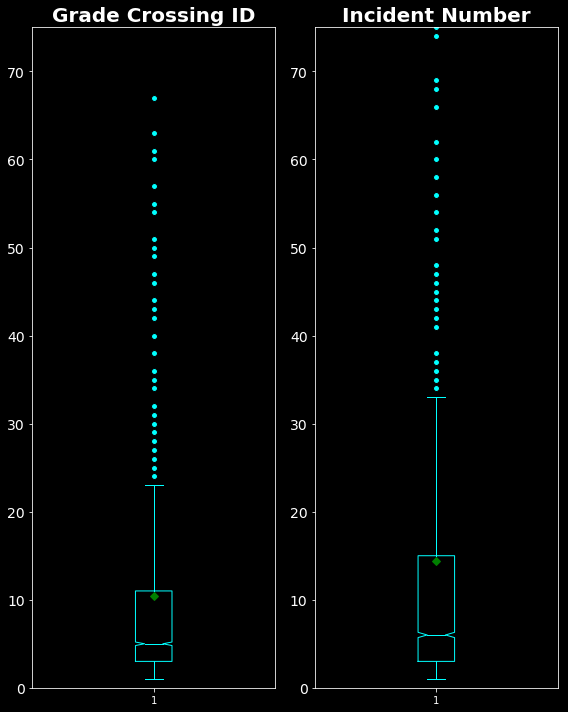

In [65]:
blue_circle = dict(markerfacecolor='cyan', marker='o')
mean_shape = dict(markerfacecolor='green', marker='D', markeredgecolor='green')

df = weather_station_stats
c = 'cyan'

fig, axs = plt.subplots(1, len(df.columns), figsize=(8,10))

for i, ax in enumerate(axs.flat):
    ax.boxplot(df.iloc[:,i], boxprops=dict(color=c), capprops=dict(color=c), whiskerprops=dict(color=c), medianprops=dict(color=c), flierprops=blue_circle, showmeans=True, meanprops=mean_shape, notch=True, vert=True)
    ax.set_title(df.columns[i], fontsize=20, fontweight='bold')
    ax.tick_params(axis='y', labelsize=14)
    ax.set_ylim(0, 75)
    
plt.tight_layout()
plt.show()

In [66]:
feature_set_w_truth_df.shape

(18173, 26)

In [67]:
feature_set_w_truth_df.groupby(['Incident Count'])['ID'].count().to_frame()

,ID
Incident Count,
0.0,14866
1.0,274
2.0,85
3.0,108
4.0,90
5.0,286
6.0,1012
7.0,7
8.0,109


In [68]:
feature_set_w_truth_df.groupby(['Risk_Level'])['ID'].count().to_frame()

,ID
Risk_Level,
High,1452
Low,14866
Medium,1855


In [69]:
feature_set_w_truth_df.head()

,ID,wcoordinateID,incident_year_month,Max Daily Precipitation,Max Daily Snow,Max Daily Snow Depth,Max Daily TempMax,Max Daily TempMin,Min Daily Precipitation,Min Daily Snow,...,Mean Daily TempMax,Mean Daily TempMin,ELEV,Maintenance Parent Railroad Code,Railroad Type,Track Type Code,State,County,Incident Count,Risk_Level
84360,USC00181790,"(39.6, -77.7)",2017_10,574.0,0.0,0.0,306.0,222.0,0.0,0.0,...,218.580645,97.096774,162.2,CSX,CL,1.0,MARYLAND,WASHINGTON,0.0,Low
84361,USC00181790,"(39.6, -77.7)",2017_10,574.0,0.0,0.0,306.0,222.0,0.0,0.0,...,218.580645,97.096774,162.2,CSX,CL,1.0,MARYLAND,WASHINGTON,0.0,Low
84362,USC00181790,"(39.6, -77.7)",2017_10,574.0,0.0,0.0,306.0,222.0,0.0,0.0,...,218.580645,97.096774,162.2,NS,1,1.0,MARYLAND,WASHINGTON,0.0,Low
84363,USC00181790,"(39.6, -77.7)",2017_10,574.0,0.0,0.0,306.0,222.0,0.0,0.0,...,218.580645,97.096774,162.2,NS,3,4.0,MARYLAND,WASHINGTON,0.0,Low
84364,USC00181790,"(39.6, -77.7)",2017_10,574.0,0.0,0.0,306.0,222.0,0.0,0.0,...,218.580645,97.096774,162.2,CSX,CL,1.0,MARYLAND,WASHINGTON,0.0,Low


In [70]:
stats_df = feature_set_w_truth_df.groupby(['Risk_Level'])['wcoordinateID'].count().reset_index().sort_values('wcoordinateID')

stats_df

,Risk_Level,wcoordinateID
0,High,1452
2,Medium,1855
1,Low,14866


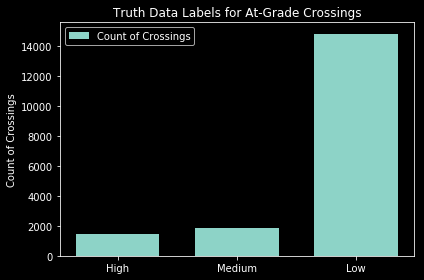

In [71]:
fig, ax = plt.subplots()
x = np.arange(len(stats_df['Risk_Level']))
width = 0.7

rects1 = ax.bar(x, stats_df['wcoordinateID'], width, label = 'Count of Crossings')
#rects2 = ax.bar(x + width/2, mode2_stats_df['Total Fatalities'], width, label = 'Incidents w Fatalities')

ax.set_title('Truth Data Labels for At-Grade Crossings')
ax.set_ylabel('Count of Crossings')
ax.set_xticks(x)
ax.set_xticklabels(stats_df['Risk_Level'])
ax.legend()

fig.tight_layout()

plt.show()

In [72]:
feature_set_w_truth_df.ID.nunique()

47

In [73]:
feature_set_w_truth_df.head()

,ID,wcoordinateID,incident_year_month,Max Daily Precipitation,Max Daily Snow,Max Daily Snow Depth,Max Daily TempMax,Max Daily TempMin,Min Daily Precipitation,Min Daily Snow,...,Mean Daily TempMax,Mean Daily TempMin,ELEV,Maintenance Parent Railroad Code,Railroad Type,Track Type Code,State,County,Incident Count,Risk_Level
84360,USC00181790,"(39.6, -77.7)",2017_10,574.0,0.0,0.0,306.0,222.0,0.0,0.0,...,218.580645,97.096774,162.2,CSX,CL,1.0,MARYLAND,WASHINGTON,0.0,Low
84361,USC00181790,"(39.6, -77.7)",2017_10,574.0,0.0,0.0,306.0,222.0,0.0,0.0,...,218.580645,97.096774,162.2,CSX,CL,1.0,MARYLAND,WASHINGTON,0.0,Low
84362,USC00181790,"(39.6, -77.7)",2017_10,574.0,0.0,0.0,306.0,222.0,0.0,0.0,...,218.580645,97.096774,162.2,NS,1,1.0,MARYLAND,WASHINGTON,0.0,Low
84363,USC00181790,"(39.6, -77.7)",2017_10,574.0,0.0,0.0,306.0,222.0,0.0,0.0,...,218.580645,97.096774,162.2,NS,3,4.0,MARYLAND,WASHINGTON,0.0,Low
84364,USC00181790,"(39.6, -77.7)",2017_10,574.0,0.0,0.0,306.0,222.0,0.0,0.0,...,218.580645,97.096774,162.2,CSX,CL,1.0,MARYLAND,WASHINGTON,0.0,Low


In [74]:
feature_set_w_truth_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18173 entries, 84360 to 112309
Data columns (total 26 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   ID                                18173 non-null  object 
 1   wcoordinateID                     18173 non-null  object 
 2   incident_year_month               18173 non-null  object 
 3   Max Daily Precipitation           18173 non-null  float64
 4   Max Daily Snow                    18173 non-null  float64
 5   Max Daily Snow Depth              18173 non-null  float64
 6   Max Daily TempMax                 18173 non-null  float64
 7   Max Daily TempMin                 18173 non-null  float64
 8   Min Daily Precipitation           18173 non-null  float64
 9   Min Daily Snow                    18173 non-null  float64
 10  Min Daily Snow Depth              18173 non-null  float64
 11  Min Daily TempMax                 18173 non-null  float64
 12 

In [75]:
weather_stats_df = feature_set_w_truth_df.describe().round(2).T.head(16).reset_index()
weather_stats_df

,index,count,mean,std,min,25%,50%,75%,max
0,Max Daily Precipitation,18173.0,332.67,202.10,0.00,198.00,287.00,424.00,1849.00
1,Max Daily Snow,18173.0,33.82,75.39,0.00,0.00,0.00,25.00,813.00
2,Max Daily Snow Depth,18173.0,37.74,89.17,0.00,0.00,0.00,25.00,813.00
3,Max Daily TempMax,18173.0,263.91,70.33,39.00,206.00,278.00,328.00,389.00
4,Max Daily TempMin,18173.0,145.42,69.16,-33.00,83.00,161.00,206.00,317.00
5,Min Daily Precipitation,18173.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,Min Daily Snow,18173.0,0.24,4.90,0.00,0.00,0.00,0.00,254.00
7,Min Daily Snow Depth,18173.0,0.99,13.42,0.00,0.00,0.00,0.00,508.00
8,Min Daily TempMax,18173.0,80.99,103.65,-217.00,0.00,72.00,178.00,322.00
9,Min Daily TempMin,18173.0,-14.72,96.15,-289.00,-89.00,-22.00,67.00,200.00


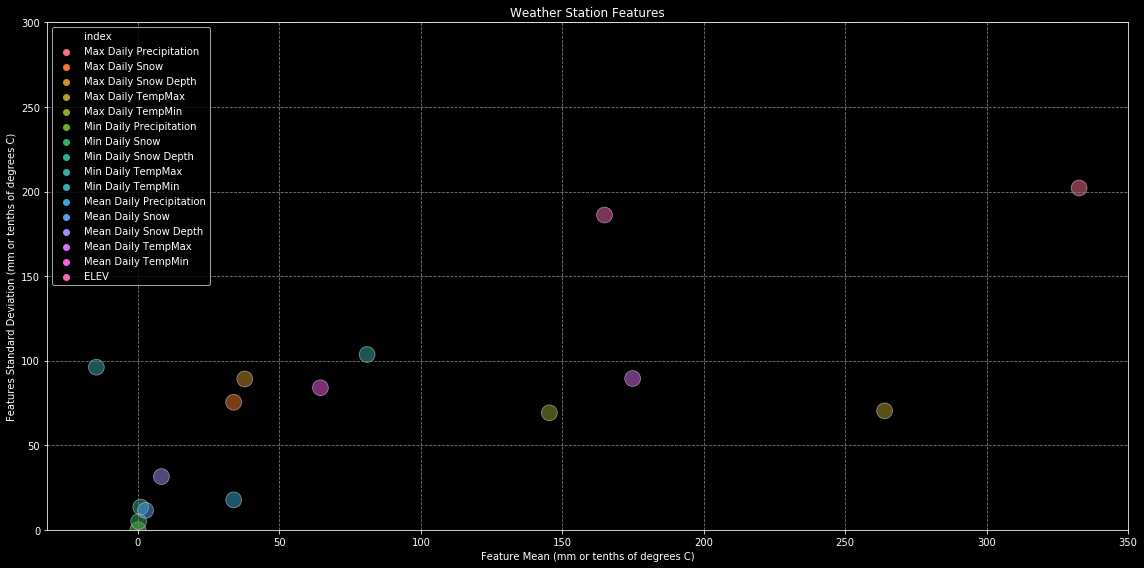

In [76]:
df = weather_stats_df


fig, ax = plt.subplots(figsize=(16,8)) 
scat = sns.scatterplot(data=df, x='mean', y='std', s=250*df['count']/(df['count'].max()), alpha=0.5, hue='index')

ax.set_ylabel('Features Standard Deviation (mm or tenths of degrees C)') 
ax.set_xlabel('Feature Mean (mm or tenths of degrees C)') 
ax.set_title('Weather Station Features') 

plt.grid(color='grey', linestyle = '--')
plt.ylim(0,300)

fig.tight_layout()
plt.show()

## 4. Prep for SciKitLearn:
____

In [77]:
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml, make_moons, make_circles, make_classification
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [78]:
COLOR = 'white'
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

In [79]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = ''
        else:
            title = ''

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()

### Treatments:

#### Test 2021

In [80]:
train_set_2021 = feature_set_w_truth_df[(feature_set_w_truth_df['incident_year_month'].str[:4]!='2021') & 
                                        (feature_set_w_truth_df['incident_year_month'].str[:4]!='2014') &
                                        (feature_set_w_truth_df['incident_year_month'].str[:4]!='2015')]
test_set_2021 = feature_set_w_truth_df[feature_set_w_truth_df['incident_year_month'].str[:4]=='2021']

In [81]:
train_set_2021.shape

(15339, 26)

In [82]:
test_set_2021.shape

(2834, 26)

#### Test 2020

In [83]:
train_set_2020 = feature_set_w_truth_df[(feature_set_w_truth_df['incident_year_month'].str[:4]!='2021') & 
                                        (feature_set_w_truth_df['incident_year_month'].str[:4]!='2020') &
                                        (feature_set_w_truth_df['incident_year_month'].str[:4]!='2014')]
test_set_2020 = feature_set_w_truth_df[feature_set_w_truth_df['incident_year_month'].str[:4]=='2020']

In [84]:
train_set_2020.shape

(12245, 26)

In [85]:
test_set_2020.shape

(3094, 26)

#### Test 2019

In [86]:
train_set_2019 = feature_set_w_truth_df[(feature_set_w_truth_df['incident_year_month'].str[:4]!='2021') & 
                                        (feature_set_w_truth_df['incident_year_month'].str[:4]!='2020') &
                                        (feature_set_w_truth_df['incident_year_month'].str[:4]!='2019')]
test_set_2019 = feature_set_w_truth_df[feature_set_w_truth_df['incident_year_month'].str[:4]=='2019']

In [87]:
train_set_2019.shape

(9259, 26)

In [88]:
test_set_2019.shape

(2986, 26)

## 5. Model Building and Evaluation:
___

## Baseline Models:

Define Key Information:

In [89]:
# classes to predict
classes = ['Low', 'Medium', 'High']

# set data_df = dataset
data_df = feature_set_w_truth_df

# features definition
categorical_features = [
                        'State',
                        'County',
                        'Maintenance Parent Railroad Code',
                        'Railroad Type', 
                        'Track Type Code',
                       ]

numeric_features = [
#                    'ELEV',
#                    'Mean Daily Precipitation',
#                    'Mean Daily Snow',
#                    'Mean Daily Snow Depth',
#                    'Mean Daily TempMax',
#                    'Mean Daily TempMin',
#                    'Max Daily Precipitation',
#                    'Max Daily Snow',
#                    'Max Daily Snow Depth',
#                    'Max Daily TempMax',
#                    'Max Daily TempMin',
#                    'Min Daily Precipitation',
#                    'Min Daily Snow',
#                    'Min Daily Snow Depth',
#                    'Min Daily TempMax',
#                    'Min Daily TempMin',
                   ]

# X represents all feature columns
X = data_df.loc[:,(categorical_features + numeric_features)]
# note y should be a "Risk class" derived from # of incidents/injuries/fatalities somehow that matches 'classes' above
y = data_df['Risk_Level']

# classifiers to try
names = ["Decision Tree", "AdaBoost", "GradientBoost"]
classifiers = [DecisionTreeClassifier(max_depth=5),
               AdaBoostClassifier(),
               GradientBoostingClassifier(),
              ]

# training set ratios
tsizes = [0.7,0.8,0.9]

Transformation of Features:

In [90]:
numeric_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

### Multi Class Baseline (Train/Test/Split Treatment):

classifier: Decision Tree
test size: 0.7
f1_score:  0.2994775882471787


c:\users\thoma\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\thoma\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


precision:  0.2718650107425457
recall:  0.3333333333333333
Normalized confusion matrix


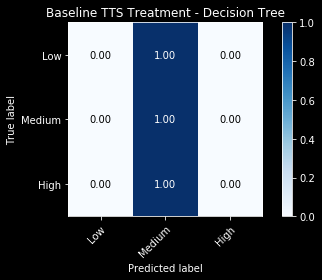

test size: 0.8


c:\users\thoma\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\thoma\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


f1_score:  0.29924184988627744
precision:  0.27147671779352084
recall:  0.3333333333333333
Normalized confusion matrix


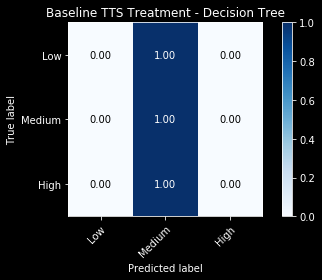

test size: 0.9
f1_score:  0.3000347444044697


c:\users\thoma\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\thoma\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


precision:  0.2727847069373115
recall:  0.3333333333333333
Normalized confusion matrix


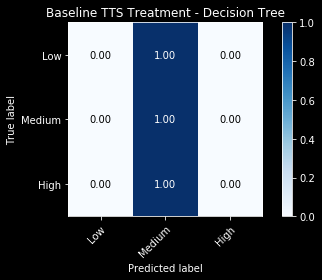

classifier: AdaBoost
test size: 0.7


c:\users\thoma\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\thoma\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


f1_score:  0.4267208460090412
precision:  0.3917483375658903
recall:  0.4796494457828895
Normalized confusion matrix


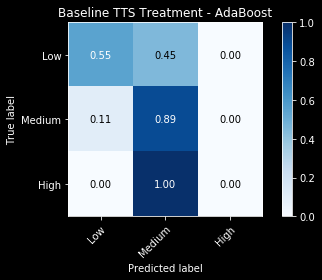

test size: 0.8
f1_score:  0.44567014918494247
precision:  0.5015782901739136
recall:  0.5035764362584491
Normalized confusion matrix


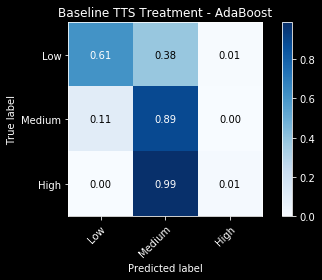

test size: 0.9
f1_score:  0.4156925217356715
precision:  0.4382633808492515
recall:  0.40578814435544125
Normalized confusion matrix


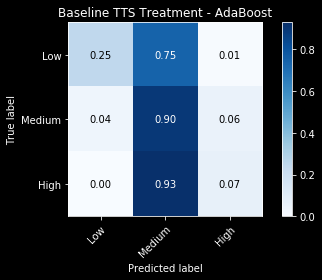

classifier: GradientBoost
test size: 0.7


c:\users\thoma\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\thoma\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


f1_score:  0.2996682532814077
precision:  0.2721794267148771
recall:  0.3333333333333333
Normalized confusion matrix


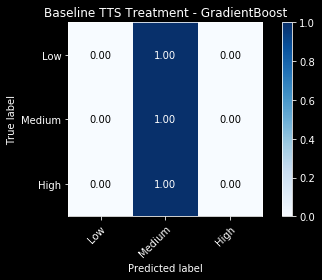

test size: 0.8


c:\users\thoma\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\thoma\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


f1_score:  0.31291908981126154
precision:  0.3866952972882885
recall:  0.3388019876574779
Normalized confusion matrix


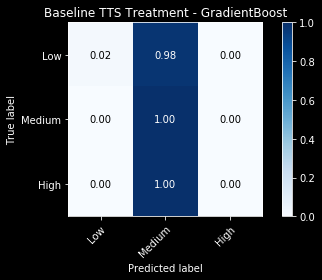

test size: 0.9
f1_score:  0.3098189457999981
precision:  0.38095634607105183
recall:  0.3368322518196794
Normalized confusion matrix


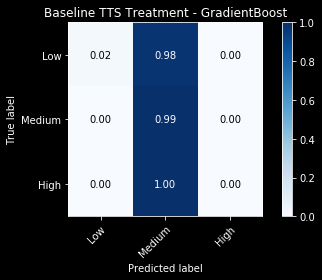

In [91]:
i = -1

for classifier in classifiers:
    # print name of classifier
    i += 1
    print('classifier: {}'.format(names[i]))
    # establish pipe
    clf = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('classifier', classifier)
        ]
    )
    
    # establish empty tsize lists
    tsize_precision = []
    tsize_recall = []
    
    for tsize in tsizes:
        # print tsize being tested
        print(f'test size: {tsize}')
        # train, test, split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=tsize)
        # fit model
        clf.fit(X_train, y_train)
        # get confusion matrix stats
        y_pred = clf.predict(X_test)
        N = confusion_matrix(y_test, y_pred, labels=classes)
        # note that in the above N, rows are true label, column predicted label, values indicate # of samples
        # utilize plot confusion matrix function from earlier
        print('f1_score:  {}'.format(f1_score(y_test, y_pred, average="macro")))
        print('precision:  {}'.format(precision_score(y_test, y_pred, average="macro")))
        print('recall:  {}'.format(recall_score(y_test, y_pred, average="macro")))
        plot_confusion_matrix(y_test, clf.predict(X_test), classes,
                          normalize=True,
                          title="Baseline TTS Treatment - {}".format(names[i]),
                          cmap=plt.cm.Blues)
        plt.show()


### Multi Class Baseline (2021 Temporal Treatment):

classifier: Decision Tree
f1_score:  0.30665650406504064
precision:  0.2839331921900729
recall:  0.3333333333333333
Normalized confusion matrix


c:\users\thoma\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\thoma\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


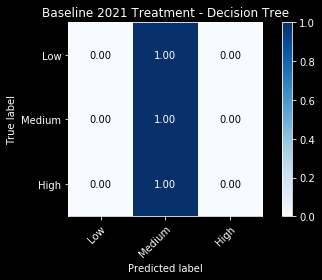

classifier: AdaBoost
f1_score:  0.3522057101037408
precision:  0.37239249639249644
recall:  0.35841130611696803
Normalized confusion matrix


c:\users\thoma\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\thoma\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


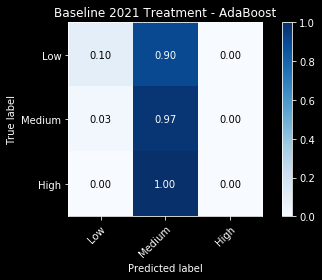

classifier: GradientBoost
f1_score:  0.30665650406504064
precision:  0.2839331921900729
recall:  0.3333333333333333
Normalized confusion matrix


c:\users\thoma\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\thoma\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


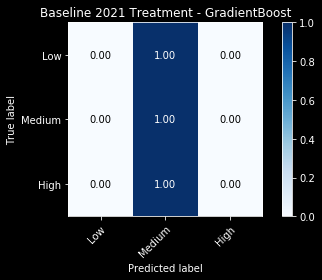

In [92]:
i = -1

for classifier in classifiers:
    # print name of classifier
    i += 1
    print('classifier: {}'.format(names[i]))
    # establish pipe
    clf = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('classifier', classifier)
        ]
    )

    # train, test, split
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=tsize)
    X_train = train_set_2021.drop('Risk_Level', 1)
    X_test = test_set_2021.drop('Risk_Level', 1)
    y_train = train_set_2021['Risk_Level']
    y_test = test_set_2021['Risk_Level']

    # fit model
    clf.fit(X_train, y_train)
    # get confusion matrix stats
    y_pred = clf.predict(X_test)
    N = confusion_matrix(y_test, y_pred, labels=classes)
    # note that in the above N, rows are true label, column predicted label, values indicate # of samples
    # utilize plot confusion matrix function from earlier
    print('f1_score:  {}'.format(f1_score(y_test, y_pred, average="macro")))
    print('precision:  {}'.format(precision_score(y_test, y_pred, average="macro")))
    print('recall:  {}'.format(recall_score(y_test, y_pred, average="macro")))
    plot_confusion_matrix(y_test, clf.predict(X_test), classes,
                      normalize=True,
                      title="Baseline 2021 Treatment - {}".format(names[i]),
                      cmap=plt.cm.Blues)
    plt.show()


### Multi Class Baseline (2020 Temporal Treatment):

classifier: Decision Tree
f1_score:  0.3004911533226818
precision:  0.27354018530489116
recall:  0.3333333333333333
Normalized confusion matrix


c:\users\thoma\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\thoma\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


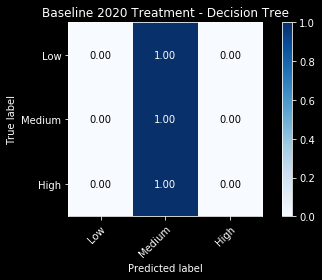

classifier: AdaBoost


c:\users\thoma\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\thoma\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


f1_score:  0.45959103551312697
precision:  0.4619371845337305
recall:  0.46065250826315013
Normalized confusion matrix


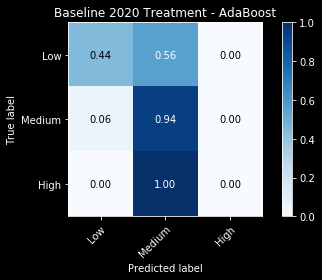

classifier: GradientBoost
f1_score:  0.3004911533226818
precision:  0.27354018530489116
recall:  0.3333333333333333
Normalized confusion matrix


c:\users\thoma\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\thoma\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


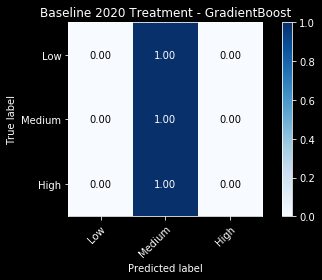

In [93]:
i = -1

for classifier in classifiers:
    # print name of classifier
    i += 1
    print('classifier: {}'.format(names[i]))
    # establish pipe
    clf = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('classifier', classifier)
        ]
    )

    # train, test, split
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=tsize)
    X_train = train_set_2020.drop('Risk_Level', 1)
    X_test = test_set_2020.drop('Risk_Level', 1)
    y_train = train_set_2020['Risk_Level']
    y_test = test_set_2020['Risk_Level']

    # fit model
    clf.fit(X_train, y_train)
    # get confusion matrix stats
    y_pred = clf.predict(X_test)
    N = confusion_matrix(y_test, y_pred, labels=classes)
    # note that in the above N, rows are true label, column predicted label, values indicate # of samples
    # utilize plot confusion matrix function from earlier
    print('f1_score:  {}'.format(f1_score(y_test, y_pred, average="macro")))
    print('precision:  {}'.format(precision_score(y_test, y_pred, average="macro")))
    print('recall:  {}'.format(recall_score(y_test, y_pred, average="macro")))
    plot_confusion_matrix(y_test, clf.predict(X_test), classes,
                      normalize=True,
                      title="Baseline 2020 Treatment - {}".format(names[i]),
                      cmap=plt.cm.Blues)
    plt.show()


### Multi Class Baseline (2019 Temporal Treatment):

classifier: Decision Tree
f1_score:  0.3027422303473492
precision:  0.27729403884795717
recall:  0.3333333333333333
Normalized confusion matrix


c:\users\thoma\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\thoma\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


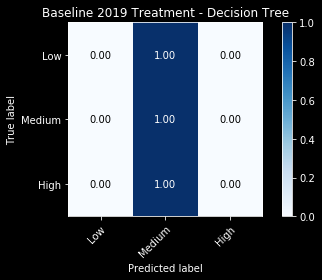

classifier: AdaBoost


c:\users\thoma\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\thoma\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


f1_score:  0.4412330173986976
precision:  0.4052525102544591
recall:  0.4910701215049041
Normalized confusion matrix


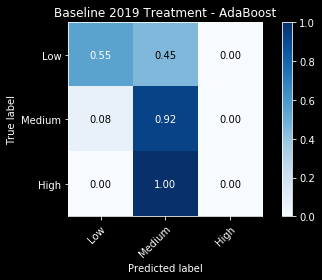

classifier: GradientBoost
f1_score:  0.3027422303473492
precision:  0.27729403884795717
recall:  0.3333333333333333
Normalized confusion matrix


c:\users\thoma\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\thoma\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


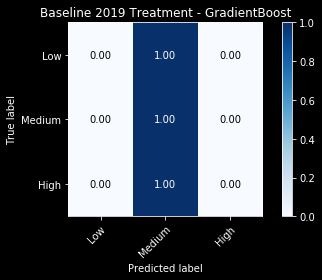

In [94]:
i = -1

for classifier in classifiers:
    # print name of classifier
    i += 1
    print('classifier: {}'.format(names[i]))
    # establish pipe
    clf = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('classifier', classifier)
        ]
    )

    # train, test, split
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=tsize)
    X_train = train_set_2019.drop('Risk_Level', 1)
    X_test = test_set_2019.drop('Risk_Level', 1)
    y_train = train_set_2019['Risk_Level']
    y_test = test_set_2019['Risk_Level']

    # fit model
    clf.fit(X_train, y_train)
    # get confusion matrix stats
    y_pred = clf.predict(X_test)
    N = confusion_matrix(y_test, y_pred, labels=classes)
    # note that in the above N, rows are true label, column predicted label, values indicate # of samples
    # utilize plot confusion matrix function from earlier
    print('f1_score:  {}'.format(f1_score(y_test, y_pred, average="macro")))
    print('precision:  {}'.format(precision_score(y_test, y_pred, average="macro")))
    print('recall:  {}'.format(recall_score(y_test, y_pred, average="macro")))
    plot_confusion_matrix(y_test, clf.predict(X_test), classes,
                      normalize=True,
                      title="Baseline 2019 Treatment - {}".format(names[i]),
                      cmap=plt.cm.Blues)
    plt.show()


## Weather Models:

Define Key Information:

In [95]:
# classes to predict
classes = ['Low', 'Medium', 'High']

# set data_df = dataset
data_df = feature_set_w_truth_df

# features definition
categorical_features = [
#                        'State',
#                        'County',
#                        'Maintenance Parent Railroad Code',
#                        'Railroad Type', 
#                        'Track Type Code',
                       ]

numeric_features = [
                    'ELEV',
                    'Mean Daily Precipitation',
                    'Mean Daily Snow',
                    'Mean Daily Snow Depth',
                    'Mean Daily TempMax',
                    'Mean Daily TempMin',
                    'Max Daily Precipitation',
                    'Max Daily Snow',
                    'Max Daily Snow Depth',
                    'Max Daily TempMax',
                    'Max Daily TempMin',
                    'Min Daily Precipitation',
                    'Min Daily Snow',
                    'Min Daily Snow Depth',
                    'Min Daily TempMax',
                    'Min Daily TempMin',
                   ]

# X represents all feature columns
X = data_df.loc[:,(categorical_features + numeric_features)]
# note y should be a "Risk class" derived from # of incidents/injuries/fatalities somehow that matches 'classes' above
y = data_df['Risk_Level']

# classifiers to try
names = ["Decision Tree", "AdaBoost", "GradientBoost"]
classifiers = [DecisionTreeClassifier(max_depth=5),
               AdaBoostClassifier(),
               GradientBoostingClassifier(),
              ]

# training set ratios
tsizes = [0.7,0.8,0.9]

Transformation of Features:

In [96]:
numeric_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

### Multi Class Weather Model (Train/Test/Split Treatment):

classifier: Decision Tree
test size: 0.7
f1_score:  0.5868553923369405
precision:  0.8036994202248038
recall:  0.5325532079801795
Normalized confusion matrix


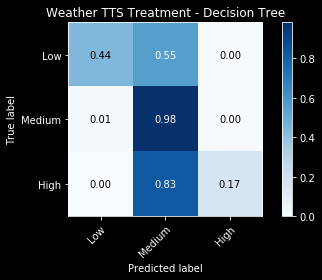

test size: 0.8
f1_score:  0.5156958921288027
precision:  0.8366604214620916
recall:  0.47114059198349306
Normalized confusion matrix


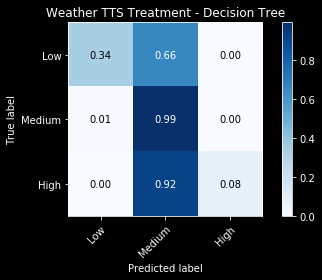

test size: 0.9
f1_score:  0.4875902477188376
precision:  0.7400039610779706
recall:  0.45104892592472906
Normalized confusion matrix


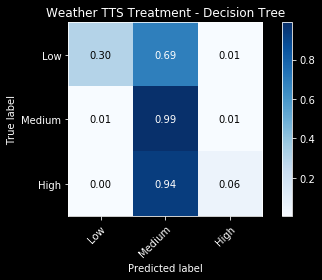

classifier: AdaBoost
test size: 0.7
f1_score:  0.5360914915756815
precision:  0.7928123599660273
recall:  0.4877969532135557
Normalized confusion matrix


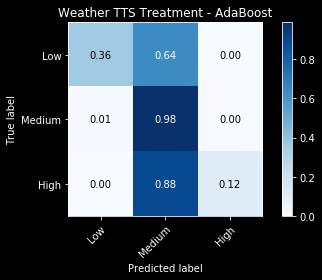

test size: 0.8
f1_score:  0.5190626498197327
precision:  0.5734329617866998
recall:  0.4895468312825635
Normalized confusion matrix


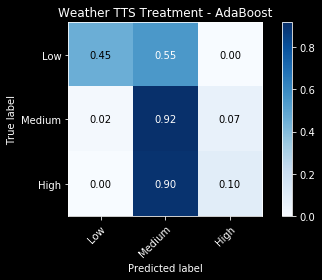

test size: 0.9
f1_score:  0.5303677765108806
precision:  0.6020809135026185
recall:  0.4950724005906451
Normalized confusion matrix


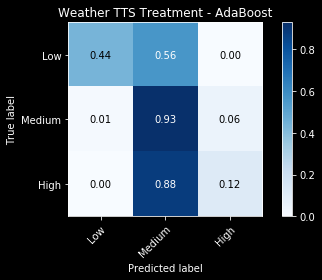

classifier: GradientBoost
test size: 0.7
f1_score:  0.870676893814725
precision:  0.977881299550071
recall:  0.8113511095030791
Normalized confusion matrix


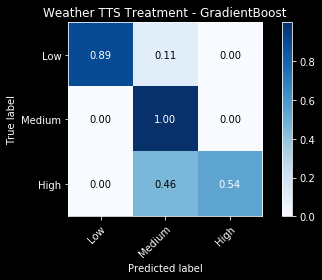

test size: 0.8
f1_score:  0.8523560185868971
precision:  0.9691681998259721
recall:  0.7930166486232557
Normalized confusion matrix


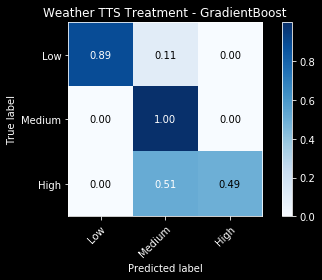

test size: 0.9
f1_score:  0.8514968622680664
precision:  0.9496178950867469
recall:  0.7976247181094949
Normalized confusion matrix


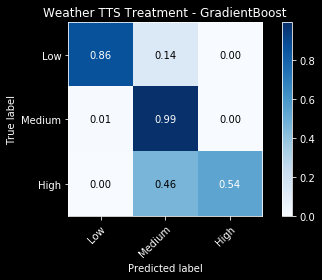

In [97]:
i = -1

for classifier in classifiers:
    # print name of classifier
    i += 1
    print('classifier: {}'.format(names[i]))
    # establish pipe
    clf = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('classifier', classifier)
        ]
    )
    
    # establish empty tsize lists
    tsize_precision = []
    tsize_recall = []
    
    for tsize in tsizes:
        # print tsize being tested
        print(f'test size: {tsize}')
        # train, test, split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=tsize)
        # fit model
        clf.fit(X_train, y_train)
        # get confusion matrix stats
        y_pred = clf.predict(X_test)
        N = confusion_matrix(y_test, y_pred, labels=classes)
        # note that in the above N, rows are true label, column predicted label, values indicate # of samples
        # utilize plot confusion matrix function from earlier
        print('f1_score:  {}'.format(f1_score(y_test, y_pred, average="macro")))
        print('precision:  {}'.format(precision_score(y_test, y_pred, average="macro")))
        print('recall:  {}'.format(recall_score(y_test, y_pred, average="macro")))
        plot_confusion_matrix(y_test, clf.predict(X_test), classes,
                          normalize=True,
                          title="Weather TTS Treatment - {}".format(names[i]),
                          cmap=plt.cm.Blues)
        plt.show()


### Multi Class Weather Model (2021 Temporal Treatment):

classifier: Decision Tree
f1_score:  0.30065865943432774
precision:  0.2823871906841339
recall:  0.32145816072908034
Normalized confusion matrix


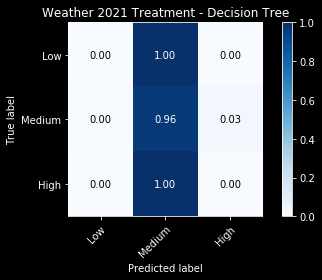

classifier: AdaBoost
f1_score:  0.30221193415637865
precision:  0.28279181708784595
recall:  0.32449599558133113
Normalized confusion matrix


c:\users\thoma\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\thoma\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


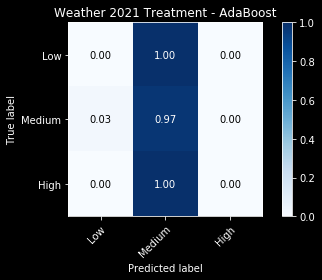

classifier: GradientBoost
f1_score:  0.39351372477706653
precision:  0.43763799787896174
recall:  0.3881688500250191
Normalized confusion matrix


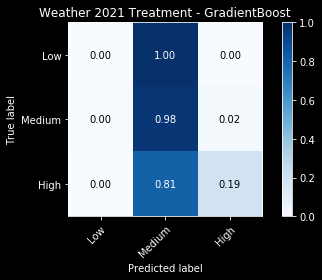

In [98]:
i = -1

for classifier in classifiers:
    # print name of classifier
    i += 1
    print('classifier: {}'.format(names[i]))
    # establish pipe
    clf = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('classifier', classifier)
        ]
    )

    # train, test, split
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=tsize)
    X_train = train_set_2021.drop('Risk_Level', 1)
    X_test = test_set_2021.drop('Risk_Level', 1)
    y_train = train_set_2021['Risk_Level']
    y_test = test_set_2021['Risk_Level']

    # fit model
    clf.fit(X_train, y_train)
    # get confusion matrix stats
    y_pred = clf.predict(X_test)
    N = confusion_matrix(y_test, y_pred, labels=classes)
    # note that in the above N, rows are true label, column predicted label, values indicate # of samples
    # utilize plot confusion matrix function from earlier
    print('f1_score:  {}'.format(f1_score(y_test, y_pred, average="macro")))
    print('precision:  {}'.format(precision_score(y_test, y_pred, average="macro")))
    print('recall:  {}'.format(recall_score(y_test, y_pred, average="macro")))
    plot_confusion_matrix(y_test, clf.predict(X_test), classes,
                      normalize=True,
                      title="Weather 2021 Treatment - {}".format(names[i]),
                      cmap=plt.cm.Blues)
    plt.show()


### Multi Class Weather Model (2020 Temporal Treatment):

classifier: Decision Tree
f1_score:  0.29990516832622094
precision:  0.2733657482441923
recall:  0.33215176578705524
Normalized confusion matrix


c:\users\thoma\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\thoma\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


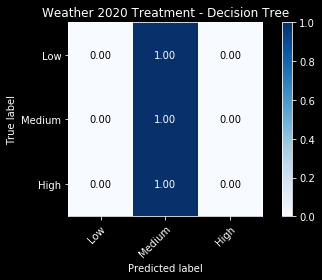

classifier: AdaBoost
f1_score:  0.5266774475478729
precision:  0.552515101370895
recall:  0.511409915508057
Normalized confusion matrix


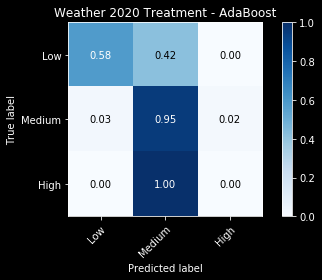

classifier: GradientBoost
f1_score:  0.290884799902836
precision:  0.27062146892655364
recall:  0.31442825259288437
Normalized confusion matrix


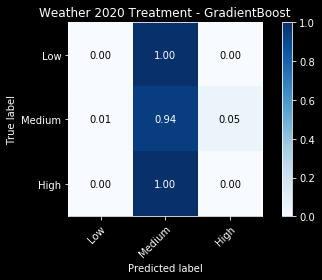

In [99]:
i = -1

for classifier in classifiers:
    # print name of classifier
    i += 1
    print('classifier: {}'.format(names[i]))
    # establish pipe
    clf = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('classifier', classifier)
        ]
    )

    # train, test, split
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=tsize)
    X_train = train_set_2020.drop('Risk_Level', 1)
    X_test = test_set_2020.drop('Risk_Level', 1)
    y_train = train_set_2020['Risk_Level']
    y_test = test_set_2020['Risk_Level']

    # fit model
    clf.fit(X_train, y_train)
    # get confusion matrix stats
    y_pred = clf.predict(X_test)
    N = confusion_matrix(y_test, y_pred, labels=classes)
    # note that in the above N, rows are true label, column predicted label, values indicate # of samples
    # utilize plot confusion matrix function from earlier
    print('f1_score:  {}'.format(f1_score(y_test, y_pred, average="macro")))
    print('precision:  {}'.format(precision_score(y_test, y_pred, average="macro")))
    print('recall:  {}'.format(recall_score(y_test, y_pred, average="macro")))
    plot_confusion_matrix(y_test, clf.predict(X_test), classes,
                      normalize=True,
                      title="Weather 2020 Treatment - {}".format(names[i]),
                      cmap=plt.cm.Blues)
    plt.show()


### Multi Class Combined Model (2019 Temporal Treatment):

classifier: Decision Tree
f1_score:  0.38203568534036036
precision:  0.4863286032087939
recall:  0.3698848066220301
Normalized confusion matrix


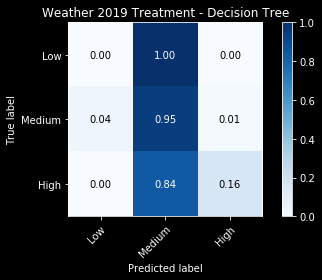

classifier: AdaBoost
f1_score:  0.40081127275648704
precision:  0.5625169101731601
recall:  0.3902884361027001
Normalized confusion matrix


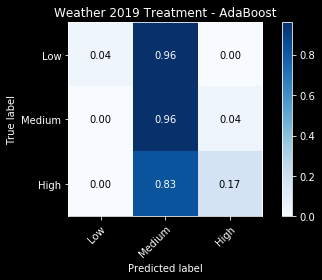

classifier: GradientBoost
f1_score:  0.36639283047050036
precision:  0.44614670380687094
recall:  0.364801395598497
Normalized confusion matrix


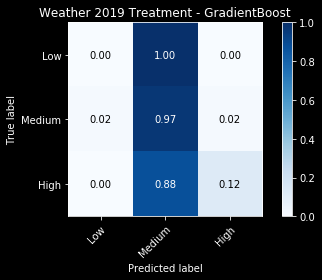

In [100]:
i = -1

for classifier in classifiers:
    # print name of classifier
    i += 1
    print('classifier: {}'.format(names[i]))
    # establish pipe
    clf = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('classifier', classifier)
        ]
    )

    # train, test, split
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=tsize)
    X_train = train_set_2019.drop('Risk_Level', 1)
    X_test = test_set_2019.drop('Risk_Level', 1)
    y_train = train_set_2019['Risk_Level']
    y_test = test_set_2019['Risk_Level']

    # fit model
    clf.fit(X_train, y_train)
    # get confusion matrix stats
    y_pred = clf.predict(X_test)
    N = confusion_matrix(y_test, y_pred, labels=classes)
    # note that in the above N, rows are true label, column predicted label, values indicate # of samples
    # utilize plot confusion matrix function from earlier
    print('f1_score:  {}'.format(f1_score(y_test, y_pred, average="macro")))
    print('precision:  {}'.format(precision_score(y_test, y_pred, average="macro")))
    print('recall:  {}'.format(recall_score(y_test, y_pred, average="macro")))
    plot_confusion_matrix(y_test, clf.predict(X_test), classes,
                      normalize=True,
                      title="Weather 2019 Treatment - {}".format(names[i]),
                      cmap=plt.cm.Blues)
    plt.show()


## Combined Models:

Define Key Information:

In [101]:
# classes to predict
classes = ['Low', 'Medium', 'High']

# set data_df = dataset
data_df = feature_set_w_truth_df

# features definition
categorical_features = [
                        'State',
                        'County',
                        'Maintenance Parent Railroad Code',
                        'Railroad Type', 
                        'Track Type Code',
                       ]

numeric_features = [
                    'ELEV',
                    'Mean Daily Precipitation',
                    'Mean Daily Snow',
                    'Mean Daily Snow Depth',
                    'Mean Daily TempMax',
                    'Mean Daily TempMin',
                    'Max Daily Precipitation',
                    'Max Daily Snow',
                    'Max Daily Snow Depth',
                    'Max Daily TempMax',
                    'Max Daily TempMin',
                    'Min Daily Precipitation',
                    'Min Daily Snow',
                    'Min Daily Snow Depth',
                    'Min Daily TempMax',
                    'Min Daily TempMin',
                   ]

# X represents all feature columns
X = data_df.loc[:,(categorical_features + numeric_features)]
# note y should be a "Risk class" derived from # of incidents/injuries/fatalities somehow that matches 'classes' above
y = data_df['Risk_Level']

# classifiers to try
names = ["Decision Tree", "AdaBoost", "GradientBoost"]
classifiers = [DecisionTreeClassifier(max_depth=5),
               AdaBoostClassifier(),
               GradientBoostingClassifier(),
              ]

# training set ratios
tsizes = [0.7,0.8,0.9]

Transformation of Features:

In [102]:
numeric_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

### Multi Class Combined Model (Train/Test/Split Treatment):

classifier: Decision Tree
test size: 0.7
f1_score:  0.5441797288704909
precision:  0.8438435605507565
recall:  0.4829079205334977
Normalized confusion matrix


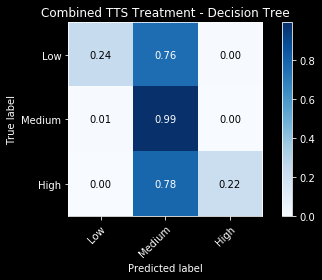

test size: 0.8
f1_score:  0.6208557213134003
precision:  0.8446045276138805
recall:  0.5754086837723837
Normalized confusion matrix


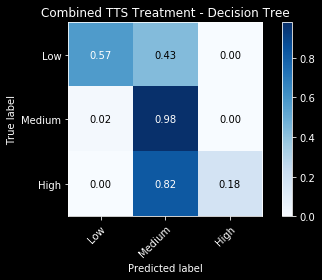

test size: 0.9
f1_score:  0.5169225623676982
precision:  0.7552826506968829
recall:  0.48573536234614595
Normalized confusion matrix


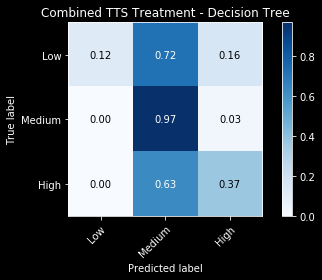

classifier: AdaBoost
test size: 0.7
f1_score:  0.5694541883006881
precision:  0.7341415193701946
recall:  0.512467664304368
Normalized confusion matrix


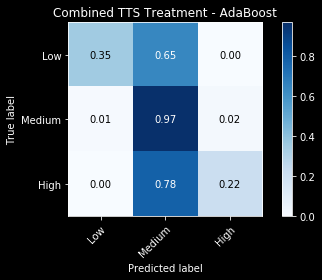

test size: 0.8
f1_score:  0.584511553895011
precision:  0.630337529391361
recall:  0.5606142968959154
Normalized confusion matrix


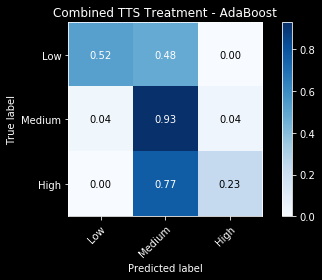

test size: 0.9
f1_score:  0.5345146034012754
precision:  0.7625214662494783
recall:  0.4900182989730766
Normalized confusion matrix


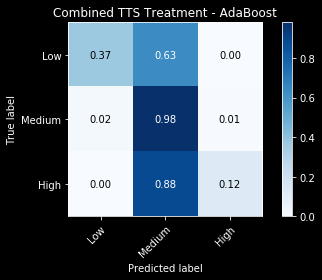

classifier: GradientBoost
test size: 0.7
f1_score:  0.874577109493552
precision:  0.9794682732368192
recall:  0.8141476813450158
Normalized confusion matrix


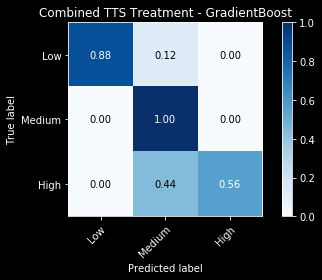

test size: 0.8
f1_score:  0.8820901847970064
precision:  0.9786468897874121
recall:  0.8258205629477388
Normalized confusion matrix


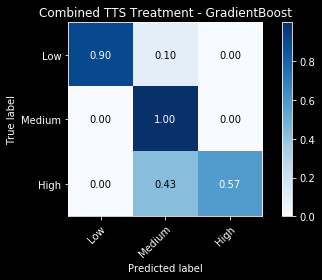

test size: 0.9
f1_score:  0.8648737737520314
precision:  0.9533413579768594
recall:  0.8097176229563486
Normalized confusion matrix


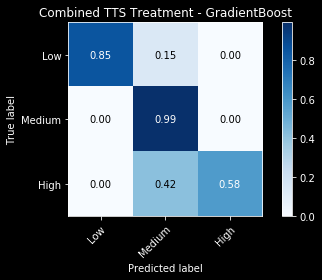

In [103]:
i = -1

for classifier in classifiers:
    # print name of classifier
    i += 1
    print('classifier: {}'.format(names[i]))
    # establish pipe
    clf = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('classifier', classifier)
        ]
    )
    
    # establish empty tsize lists
    tsize_precision = []
    tsize_recall = []
    
    for tsize in tsizes:
        # print tsize being tested
        print(f'test size: {tsize}')
        # train, test, split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=tsize)
        # fit model
        clf.fit(X_train, y_train)
        # get confusion matrix stats
        y_pred = clf.predict(X_test)
        N = confusion_matrix(y_test, y_pred, labels=classes)
        # note that in the above N, rows are true label, column predicted label, values indicate # of samples
        # utilize plot confusion matrix function from earlier
        print('f1_score:  {}'.format(f1_score(y_test, y_pred, average="macro")))
        print('precision:  {}'.format(precision_score(y_test, y_pred, average="macro")))
        print('recall:  {}'.format(recall_score(y_test, y_pred, average="macro")))
        plot_confusion_matrix(y_test, clf.predict(X_test), classes,
                          normalize=True,
                          title="Combined TTS Treatment - {}".format(names[i]),
                          cmap=plt.cm.Blues)
        plt.show()


### Multi Class Combined Model (2021 Temporal Treatment):

classifier: Decision Tree
f1_score:  0.4131847710338639
precision:  0.6123821102269379
recall:  0.3943826031318956
Normalized confusion matrix


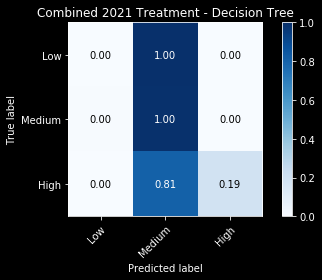

classifier: AdaBoost
f1_score:  0.42358932107170816
precision:  0.4501772554340597
recall:  0.45410783258878173
Normalized confusion matrix


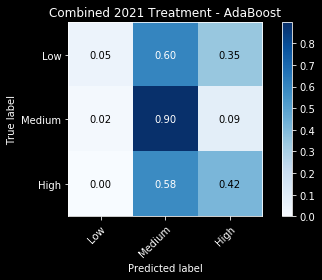

classifier: GradientBoost
f1_score:  0.4454414000498106
precision:  0.45544340219450596
recall:  0.4421758663024546
Normalized confusion matrix


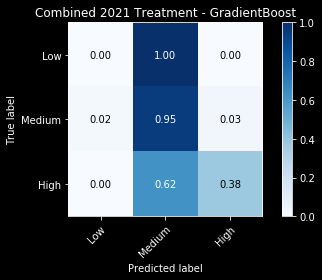

In [104]:
i = -1

for classifier in classifiers:
    # print name of classifier
    i += 1
    print('classifier: {}'.format(names[i]))
    # establish pipe
    clf = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('classifier', classifier)
        ]
    )

    # train, test, split
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=tsize)
    X_train = train_set_2021.drop('Risk_Level', 1)
    X_test = test_set_2021.drop('Risk_Level', 1)
    y_train = train_set_2021['Risk_Level']
    y_test = test_set_2021['Risk_Level']

    # fit model
    clf.fit(X_train, y_train)
    # get confusion matrix stats
    y_pred = clf.predict(X_test)
    N = confusion_matrix(y_test, y_pred, labels=classes)
    # note that in the above N, rows are true label, column predicted label, values indicate # of samples
    # utilize plot confusion matrix function from earlier
    print('f1_score:  {}'.format(f1_score(y_test, y_pred, average="macro")))
    print('precision:  {}'.format(precision_score(y_test, y_pred, average="macro")))
    print('recall:  {}'.format(recall_score(y_test, y_pred, average="macro")))
    plot_confusion_matrix(y_test, clf.predict(X_test), classes,
                      normalize=True,
                      title="Combined 2021 Treatment - {}".format(names[i]),
                      cmap=plt.cm.Blues)
    plt.show()


### Multi Class  Combined Model (2020 Temporal Treatment):

classifier: Decision Tree
f1_score:  0.2952157992676631
precision:  0.2719531077195311
recall:  0.32283051069975055
Normalized confusion matrix


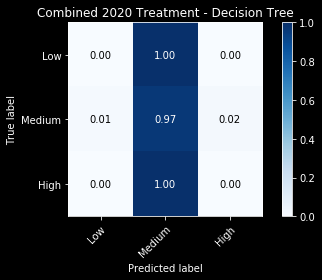

classifier: AdaBoost
f1_score:  0.37016684478553036
precision:  0.453926832375895
recall:  0.3738385662917765
Normalized confusion matrix


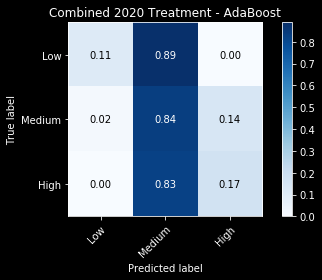

classifier: GradientBoost
f1_score:  0.3321248749260243
precision:  0.4066871741599614
recall:  0.3301151433152323
Normalized confusion matrix


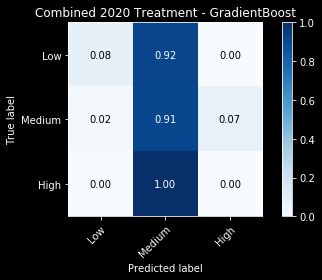

In [105]:
i = -1

for classifier in classifiers:
    # print name of classifier
    i += 1
    print('classifier: {}'.format(names[i]))
    # establish pipe
    clf = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('classifier', classifier)
        ]
    )

    # train, test, split
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=tsize)
    X_train = train_set_2020.drop('Risk_Level', 1)
    X_test = test_set_2020.drop('Risk_Level', 1)
    y_train = train_set_2020['Risk_Level']
    y_test = test_set_2020['Risk_Level']

    # fit model
    clf.fit(X_train, y_train)
    # get confusion matrix stats
    y_pred = clf.predict(X_test)
    N = confusion_matrix(y_test, y_pred, labels=classes)
    # note that in the above N, rows are true label, column predicted label, values indicate # of samples
    # utilize plot confusion matrix function from earlier
    print('f1_score:  {}'.format(f1_score(y_test, y_pred, average="macro")))
    print('precision:  {}'.format(precision_score(y_test, y_pred, average="macro")))
    print('recall:  {}'.format(recall_score(y_test, y_pred, average="macro")))
    plot_confusion_matrix(y_test, clf.predict(X_test), classes,
                      normalize=True,
                      title="Combined 2020 Treatment - {}".format(names[i]),
                      cmap=plt.cm.Blues)
    plt.show()


### Multi Class Combined Model (2019 Temporal Treatment):

classifier: Decision Tree
f1_score:  0.48266295508091045
precision:  0.5710972182074981
recall:  0.4699799610650106
Normalized confusion matrix


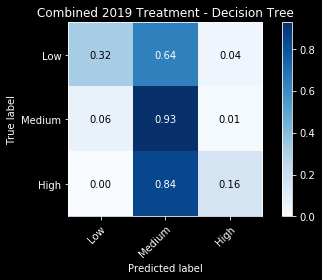

classifier: AdaBoost
f1_score:  0.473589916210875
precision:  0.7331994582730118
recall:  0.4345187188436616
Normalized confusion matrix


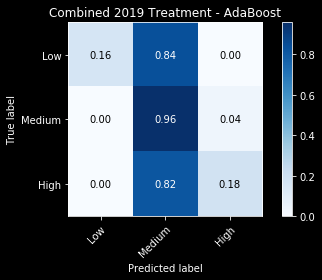

classifier: GradientBoost
f1_score:  0.40907893148190744
precision:  0.44590533433508645
recall:  0.3947872444249256
Normalized confusion matrix


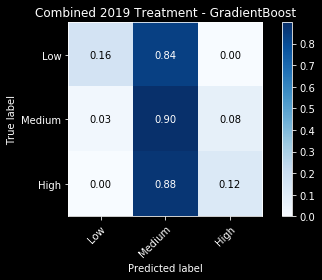

In [106]:
i = -1

for classifier in classifiers:
    # print name of classifier
    i += 1
    print('classifier: {}'.format(names[i]))
    # establish pipe
    clf = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('classifier', classifier)
        ]
    )

    # train, test, split
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=tsize)
    X_train = train_set_2019.drop('Risk_Level', 1)
    X_test = test_set_2019.drop('Risk_Level', 1)
    y_train = train_set_2019['Risk_Level']
    y_test = test_set_2019['Risk_Level']

    # fit model
    clf.fit(X_train, y_train)
    # get confusion matrix stats
    y_pred = clf.predict(X_test)
    N = confusion_matrix(y_test, y_pred, labels=classes)
    # note that in the above N, rows are true label, column predicted label, values indicate # of samples
    # utilize plot confusion matrix function from earlier
    print('f1_score:  {}'.format(f1_score(y_test, y_pred, average="macro")))
    print('precision:  {}'.format(precision_score(y_test, y_pred, average="macro")))
    print('recall:  {}'.format(recall_score(y_test, y_pred, average="macro")))
    plot_confusion_matrix(y_test, clf.predict(X_test), classes,
                      normalize=True,
                      title="Combined 2019 Treatment - {}".format(names[i]),
                      cmap=plt.cm.Blues)
    plt.show()
